In [1]:
#imports 
import os
import numpy as np
import math
import random
from collections import Counter
from PIL import Image
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.nn.init as init

import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms.functional as f
import torchvision.models as models

import torch.optim as optim

import dgl
import dgl.function as fn
from dgl.nn import GraphConv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

C:\Users\EXTREME_RED\AppData\Local\Temp\ipykernel_17184\1308320785.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


device(type='cuda', index=0)

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
#location of the data 
data_location =  "D:\\WORK\\M.SC\\MSC_Project\\GitHub\\Dataset\\Flicker8k_Dataset\\"
!ls $data_location

1000268201_693b08cb0e.jpg
1001773457_577c3a7d70.jpg
1002674143_1b742ab4b8.jpg
1003163366_44323f5815.jpg
1007129816_e794419615.jpg
1007320043_627395c3d8.jpg
1009434119_febe49276a.jpg
1012212859_01547e3f17.jpg
1015118661_980735411b.jpg
1015584366_dfcec3c85a.jpg
101654506_8eb26cfb60.jpg
101669240_b2d3e7f17b.jpg
1016887272_03199f49c4.jpg
1019077836_6fc9b15408.jpg
1019604187_d087bf9a5f.jpg
1020651753_06077ec457.jpg
1022454332_6af2c1449a.jpg
1022454428_b6b660a67b.jpg
1022975728_75515238d8.jpg
102351840_323e3de834.jpg
1024138940_f1fefbdce1.jpg
102455176_5f8ead62d5.jpg
1026685415_0431cbf574.jpg
1028205764_7e8df9a2ea.jpg
1030985833_b0902ea560.jpg
103106960_e8a41d64f8.jpg
103195344_5d2dc613a3.jpg
103205630_682ca7285b.jpg
1032122270_ea6f0beedb.jpg
1032460886_4a598ed535.jpg
1034276567_49bb87c51c.jpg
104136873_5b5d41be75.jpg
1042020065_fb3d3ba5ba.jpg
1042590306_95dea0916c.jpg
1045521051_108ebc19be.jpg
1048710776_bb5b0a5c7c.jpg
1052358063_eae6744153.jpg
105342180_4d4a40b47f.jpg
1053804096_ad278b25f1

In [4]:
#reading the text data 
caption_file = 'train.csv'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 14575 image to captions


,image,caption,relationships
0,80.jpg,This is a cute little kitchen. It had brown wo...,"jar holding utensil, rug ON floor"
1,84.jpg,The doors leading to the outside of the home a...,"tassels ON pillow, candle on top of books, tab..."
2,99.jpg,There are several tables with white table clot...,"candle ON candle stand, flame ON candle, paint..."
3,108.jpg,"Cars pedestrians, and scooters or motorcycles ...","sign ON pole, tree ON street, pole with sign, ..."
4,121.jpg,There is a large white book shelf against the ...,"hole IN guitar, dvd IN shelf, dvd on a shelf, ..."
5,131.jpg,a bunch of people are walking in a town. they ...,"woman sitting on bench, shoe OF person, shoe o..."
6,137.jpg,The sky is overcast and cloudy. There's a bike...,"sign ON pole, bicycle ON pole, bicycle ON side..."


In [5]:
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

In [6]:
class Vocabulary:
    def __init__(self,freq_threshold):

        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [7]:
class ObjectDetectorAndFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True, iou_threshold=0.1):
        super(ObjectDetectorAndFeatureExtractor, self).__init__()

        # Object detection model (Faster R-CNN)
        self.object_detection_model = fasterrcnn_resnet50_fpn(pretrained=pretrained)
        self.object_detection_model.eval()

        # Feature extraction model (VGG19)
        vgg = models.vgg19(pretrained=pretrained)
        for param in vgg.parameters():
            param.requires_grad = False
        self.feature_extractor = vgg.features[:36]
        self.feature_extractor = nn.Sequential(*self.feature_extractor)
        self.iou_threshold = iou_threshold

    def forward(self, image):
        #graph_list = []
        image = image.to(device)
        #for image in images:
        # Perform object detection
        with torch.no_grad():
            detections = self.object_detection_model([image])

        g = dgl.DGLGraph()
        g = g.to(device)

        if len(detections[0]['boxes']) == 0:
            # No objects detected; use whole image features
            image_feature = self.feature_extractor(image.unsqueeze(0))
            image_feature = image_feature.view(image_feature.size(0), 49, -1)  # (batch_size, 49, 2048)
            g.add_nodes(1, {'features': image_feature})
            g.add_edges(0, 0)  # self-loop edge
            #graph_list.append(g)
            return g

        # Add nodes for each detected object and assign features
        for box in detections[0]['boxes']:
            x1, y1, x2, y2 = map(int, box.tolist())
            if x1 >= x2 or y1 >= y2:
                # Invalid bounding box, skip it
                continue

            # Extract object region
            object_region = image[:, y1:y2, x1:x2]
            if object_region.size(1) == 0 or object_region.size(2) == 0:
                # Zero-size crop, skip it
                continue

            # Resize to a common size
            object_region = f.resize(object_region, (224, 224))  

            # Extract features using VGG19
            features = self.feature_extractor(object_region.unsqueeze(0))
            features = features.view(features.size(0), 49, -1)  # (batch_size, 49, 2048)
            g.add_nodes(1, {'features': features})

        num_objects = g.number_of_nodes()

        # Add edges based on IoU
        for i in range(num_objects):
            for j in range(num_objects):
                if i != j:
                    bbox_i = detections[0]['boxes'][i]
                    bbox_j = detections[0]['boxes'][j]
                    iou = self.calculate_iou(bbox_i, bbox_j)
                    if iou > self.iou_threshold:
                        g.add_edges(i, j)

        #graph_list.append(g)
        #g = dgl.batch(graph_list)
        return g

    def calculate_iou(self, bbox1, bbox2):
        xmin = max(bbox1[0], bbox2[0])
        ymin = max(bbox1[1], bbox2[1])
        xmax = min(bbox1[2], bbox2[2])
        ymax = min(bbox1[3], bbox2[3])

        intersection_area = max(0, xmax - xmin) * max(0, ymax - ymin)

        area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
        union_area = area1 + area2 - intersection_area

        if union_area == 0:
            return 0

        iou = intersection_area / union_area
        return iou


In [8]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

        self.graphs = ObjectDetectorAndFeatureExtractor().to(device)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        # Convert PIL Image to Tensor
        #img_tensor = T.ToTensor()(img).to(self.device)
        
        # Get the object detection graph
        graph = self.graphs(img)
        
        return img, torch.tensor(caption_vec), graph

In [9]:
class CapsCollate:

    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        # Extract images, captions, and graphs from the batch
        imgs = [item[0] for item in batch]
        captions = [item[1] for item in batch]
        graphs = [item[2] for item in batch]
        
        # Concatenate images into a single tensor
        imgs = torch.stack(imgs, dim=0)
        
        # Pad captions to ensure consistent lengths within the batch
        padded_captions = pad_sequence(captions, batch_first=self.batch_first, padding_value=self.pad_idx)
        
        # Batch the graphs to handle multiple graphs in a single input
        batched_graphs = dgl.batch(graphs)

        return imgs, padded_captions, batched_graphs

In [10]:
#Helper function to plot the Tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
class test_FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

        self.graphs = ObjectDetectorAndFeatureExtractor().to(device)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        '''caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]'''

        # Convert PIL Image to Tensor
        #img_tensor = T.ToTensor()(img).to(self.device)
        
        # Get the object detection graph
        graph = self.graphs(img)
        
        #return img, torch.tensor(caption_vec), graph
        return img, caption, graph

class TestCapsCollate:

    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        # Extract images, captions, and graphs from the batch
        imgs = [item[0] for item in batch]
        captions = [item[1] for item in batch]
        graphs = [item[2] for item in batch]
        
        # Concatenate images into a single tensor
        imgs = torch.stack(imgs, dim=0)
        
        # Pad captions to ensure consistent lengths within the batch
        #padded_captions = pad_sequence(captions, batch_first=self.batch_first, padding_value=self.pad_idx)
        
        # Batch the graphs to handle multiple graphs in a single input
        batched_graphs = dgl.batch(graphs)

        return imgs, captions, batched_graphs    

In [12]:
#Initiate the Dataset and Dataloader


BATCH_SIZE = 128

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#dataset class
train_dataset =  FlickrDataset(
    root_dir = data_location,
    captions_file = "train_captions.txt",  
    transform=transforms
)

test_dataset =  test_FlickrDataset(
    root_dir = data_location,
    captions_file = "test_captions.txt",
    transform=transforms
)

#token to represent the padding
pad_idx = train_dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
    # batch_first=False
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=TestCapsCollate(pad_idx=pad_idx,batch_first=True) #change to TestCapsCollate
    # batch_first=False
)
#vocab_size
vocab_size = len(train_dataset.vocab)



c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights

In [13]:
class EncoderCNN(nn.Module):
    def __init__(self, pretrained=True):
        super(EncoderCNN, self).__init__()
        
        # Load pre-trained VGG19 for feature extraction
        vgg = models.vgg19(pretrained=pretrained)
        for param in vgg.parameters():
            param.requires_grad_(False)
        self.vgg_features = vgg.features[:36]
        self.vgg_features = nn.Sequential(*self.vgg_features)
        
        
    def forward(self, images):
        features = self.vgg_features(images)  # (batch_size, 512, 14, 14)
        
        # Reshape the feature map
        features = features.view(features.size(0), -1, 49)  # (batch_size, 2048, 49)
        features = features.permute(0, 2, 1)  # (batch_size, 49, 2048)        

        return features

In [14]:
class GCN(nn.Module):
    def __init__(self, in_feats):
        super(GCN, self).__init__()
        
        # Define GCN layers
        self.conv1 = GraphConv(in_feats, in_feats, weight=False, bias=False ,allow_zero_in_degree=True)
        self.conv2 = GraphConv(in_feats, in_feats, weight=False, bias=False, allow_zero_in_degree=True)
        
        # Define linear layer for edge computation
        self.edge_linear = nn.Linear(in_feats * 2, in_feats)
        
    def forward(self, g):
        
        h = g.ndata['features']
        # Perform GCN
        h = self.conv1(g, h)
        h = torch.relu(h)
        h = self.conv2(g, h)
        #h = torch.relu(h)
        # Concatenate src and dest node features for all edges
        src_feats = h[g.edges()[0]]
        dst_feats = h[g.edges()[1]]
        
        edge_feats = torch.cat([src_feats, dst_feats],dim=2)
        edge_values = self.edge_linear(edge_feats).squeeze(dim=1)
     
        g.edata['edge_values'] = edge_values
        
        mean_edge_feat = dgl.readout_edges(g, 'edge_values', op='mean')
        #print(mean_edge_feat.shape)
        return mean_edge_feat


In [15]:
# Positional encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pos_enc = torch.zeros(max_len, d_model)
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pos_enc", pos_enc)

    def forward(self, x):
        x = x + self.pos_enc[: x.size(1), :]
        return self.dropout(x)

In [16]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads, attention_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.attention_dim = attention_dim
        self.head_dim = attention_dim // num_heads
        
        self.linear = nn.Linear(input_dim, attention_dim)
        self.output_linear = nn.Linear(attention_dim, input_dim)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        # Use Xavier/Glorot initialization for the linear layers
        init.xavier_uniform_(self.linear.weight)
        init.xavier_uniform_(self.output_linear.weight)

    def forward(self, inputs):
        batch_size, seq_length, input_dim = inputs.size()
        
        projected_inputs = self.linear(inputs)  # (batch_size, seq_length, attention_dim)
        reshaped_inputs = projected_inputs.view(batch_size, seq_length, self.num_heads, self.head_dim) \
                                          .permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, head_dim)
        
        # Calculate attention energy
        transposed_inputs = reshaped_inputs.transpose(-2, -1)  # (batch_size, num_heads, head_dim, seq_length)
        energy = torch.matmul(reshaped_inputs, transposed_inputs)  # (batch_size, num_heads, seq_length, seq_length)
        
        # Calculate attention weights
        attention = F.softmax(energy / torch.sqrt(torch.tensor(self.head_dim, dtype=inputs.dtype)), dim=-1)  # (batch_size, num_heads, seq_length, seq_length)
        
        # Apply attention to get the context
        context = torch.matmul(attention, reshaped_inputs)  # (batch_size, num_heads, seq_length, head_dim)
        
        # Rearrange context and prepare output
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.attention_dim)  # (batch_size, seq_length, attention_dim)
        output = self.output_linear(context)  # (batch_size, seq_length, input_dim)
        
        # Optionally return attention for visualization/debugging
        return output


In [17]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, num_heads, attention_dim):
        super(MultiHeadCrossAttention, self).__init__()
        self.num_heads = num_heads
        self.attention_dim = attention_dim
        self.head_dim = attention_dim // num_heads
        
        self.encoder_linear = nn.Linear(encoder_dim, attention_dim)
        self.decoder_linear = nn.Linear(decoder_dim, self.head_dim)
        self.output_linear = nn.Linear(attention_dim, decoder_dim)
        
        self._init_weights()
        
    def _init_weights(self):
        # Initialize weights with Xavier/Glorot
        init.xavier_uniform_(self.encoder_linear.weight)
        init.xavier_uniform_(self.decoder_linear.weight)
        init.xavier_uniform_(self.output_linear.weight)
        
    def forward(self, encoder_out, decoder_hidden):
        batch_size, num_features, _ = encoder_out.size()

        encoder_proj = self.encoder_linear(encoder_out)  # (batch_size, num_features, attention_dim)
        decoder_proj = self.decoder_linear(decoder_hidden)  # (batch_size, head_dim)
        
        # Prepare the reshaped encoder projection
        encoder_proj = encoder_proj.view(batch_size, self.num_heads, num_features, self.head_dim)  # (batch_size, num_heads, num_features, head_dim)
        
        # Reshape decoder projection for cross-attention
        decoder_proj = decoder_proj.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, head_dim)
        
        # Compute energy for cross-attention
        energy = torch.matmul(encoder_proj, decoder_proj.transpose(-2, -1))  # (batch_size, num_heads, num_features, 1)
        
        # Apply scaled dot-product softmax for attention scores
        attention = F.softmax(energy / torch.sqrt(torch.tensor(self.head_dim, dtype=encoder_out.dtype)), dim=-2)  # (batch_size, num_heads, num_features, 1)
        
        # Get context by applying attention to encoder projections
        context = torch.matmul(attention.transpose(-2, -1), encoder_proj).squeeze(-2)  # (batch_size, num_heads, head_dim)
        
        # Merge multi-head context into one attention_dim
        context = context.view(batch_size, self.head_dim * self.num_heads)  # (batch_size, attention_dim)
        
        # Final output with a linear layer
        output = self.output_linear(context)  # (batch_size, decoder_dim)

        return output, attention.squeeze(-1)  # Squeeze to get (batch_size, num_heads, num_features)


In [18]:
import heapq
class Beam:
    def __init__(self, score, seq, h, c, alphas):
        self.score = score
        self.seq = seq
        self.h = h
        self.c = c
        self.alphas = alphas

    def __lt__(self, other):
        # For heapq to order the beams, based on score
        return self.score < other.score

In [49]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, gcn_encode_dim, encoder_dim, decoder_dim, num_heads, drop_prob=0.2):
        super().__init__()

        # Save the model parameters
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.num_heads = num_heads
        
        self.edge_feature = GCN(gcn_encode_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Add positional encoding
        self.positional_encoding = PositionalEncoding(embed_size, max_len=100)
        # Multi-head cross attention
        self.attention = MultiHeadCrossAttention(encoder_dim, decoder_dim, num_heads, attention_dim)
        # Multi-head self-attention
        self.attention_self = MultiHeadSelfAttention(embed_size, num_heads, attention_dim) 

        #self.attention = MultiHeadBahdanauAttention(encoder_dim, decoder_dim, attention_dim, num_heads)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size + decoder_dim, decoder_dim, bias=True)
        self.encoded_drop = nn.Dropout(drop_prob)
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, encoded_input, captions, graphs):
        embeds = self.embedding(captions)
        embeds = self.positional_encoding(embeds)
                
        seq_length = len(captions[0])-1 # Exclude the last one
        batch_size = captions.size(0)

        edge_features = self.edge_feature(graphs)
        #encoder_out = encoded_input + edge_features
        encoder_out = torch.cat((encoded_input, edge_features), dim=2)


        h, c = self.init_hidden_state(encoder_out)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, seq_length, self.num_heads,  encoder_out.size(1)).to(encoder_out.device)


        for s in range(seq_length):
            # Multi-head self-attention over captions
            embeds_attended_self = self.attention_self(embeds)
            #print("self Attention output: ",embeds_attended_self.shape)

            # Multi-head cross-attention with encoder output
            encoder_out = self.encoded_drop(encoder_out)
            output, alpha = self.attention(encoder_out, h)
            #print("Attention output: ",output.shape)
            
            #lstm_input = torch.cat((embeds[:, s], output), dim=1)
            lstm_input = torch.cat((embeds_attended_self[:, s], output), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            
            preds[:, s] = output
            alphas[:, s] = alpha

        #return preds, alphas, alphas_self
        return preds, alphas

    def generate_caption_beam(self, encoder_out, beam_width=7, max_len=20, vocab=None):
        batch_size = encoder_out.size(0)
        print("Print Batch size: ",batch_size)
        assert batch_size == 1, "Beam search requires a batch size of 1."
        
        h, c = self.init_hidden_state(encoder_out)

        # Start with the <SOS> token
        start_word = vocab.stoi['<SOS>']
        end_word = vocab.stoi['<EOS>']
        
        # Create the initial beam
        initial_beam = Beam(0.0, [start_word], h, c, [])
        # Use a heap to keep track of the top beams
        heap = [initial_beam]

        for _ in range(max_len):
            # Temporary heap to store the new beams
            new_heap = []

            # Iterate through each beam in the current heap
            while heap:
                # Get the current beam with the highest score
                current_beam = heapq.heappop(heap)

                last_word = current_beam.seq[-1]
                print(last_word)
                # If the last word in the sequence is <EOS>, continue to the next beam
                if last_word == end_word:
                    new_heap.append(current_beam)
                    continue

                # Embedding for the last word in the sequence
                embeds = self.embedding(torch.tensor([last_word]).to(encoder_out.device))
                embeds=embeds.unsqueeze(0)
                embeds = self.positional_encoding(embeds)
                print(embeds.shape)
                # Multi-head self-attention and cross-attention
                embeds_attended_self = self.attention_self(embeds)

                output, alpha = self.attention(encoder_out, current_beam.h)
                
                # LSTM step
                lstm_input = torch.cat((embeds_attended_self[:, 0], output), dim=1)
                new_h, new_c = self.lstm_cell(lstm_input, (current_beam.h, current_beam.c))

                # Prediction and log probabilities
                output = self.fcn(self.drop(new_h))
                log_probs = F.log_softmax(output, dim=1)
                
                # Keep the top beam_width predictions
                top_log_probs, top_idx = log_probs.topk(beam_width, dim=1)

                # Create new beams for each top prediction
                for i in range(beam_width):
                    new_score = current_beam.score + top_log_probs[0, i].item()
                    new_seq = current_beam.seq + [top_idx[0, i].item()]
                    new_alphas = current_beam.alphas + [alpha.cpu().detach().numpy()]
                    new_heap.append(Beam(new_score, new_seq, new_h, new_c, new_alphas))
            
            # Retain only the top beams
            heap = heapq.nlargest(beam_width, new_heap)

        # The best beam is the one with the highest score at the end
        best_beam = heapq.nlargest(1, heap)[0]

        # Convert sequence of indices to words
        caption = [vocab.itos[idx] for idx in best_beam.seq]
        
        return caption, best_beam.alphas
    
    def generate_caption(self, encoder_out, max_len=20, vocab=None):
        batch_size = encoder_out.size(0)
        h, c = self.init_hidden_state(encoder_out)

        alphas = []
        captions = []

        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(encoder_out.device)
        embeds = self.embedding(word)
        # Apply positional encoding to the first embedding
        embeds = self.positional_encoding(embeds)

        for i in range(max_len):
            
            embeds_attended_self = self.attention_self(embeds)

            output, alpha = self.attention(encoder_out, h)
            alphas.append(alpha.cpu().detach().numpy())

            #lstm_input = torch.cat((embeds[:, 0], output), dim=1)
            lstm_input = torch.cat((embeds_attended_self[:, 0], output), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            predicted_word_idx = output.argmax(dim=1)
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            else:
                captions.append(predicted_word_idx.item())
                
            # Re-apply positional encoding for each new token
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
            embeds = self.positional_encoding(embeds)  # Ensure consistent positional encoding


        #return [vocab.itos[idx] for idx in captions], alphas, alphas_self
        return [vocab.itos[idx] for idx in captions], alphas    

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [50]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,gcn_encode_dim,encoder_dim,decoder_dim,drop_prob=0.2):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = Decoder(
            embed_size=embed_size,
            vocab_size = len(train_dataset.vocab),
            attention_dim=attention_dim,
            gcn_encode_dim = gcn_encode_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            num_heads = 1
        )
        
    def forward(self, images, captions, graphs):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, graphs)
        return outputs


In [51]:
#init model
learning_rate = 1e-3
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(train_dataset.vocab),
    attention_dim=256,
    gcn_encode_dim = 2048,
    encoder_dim=4096,
    decoder_dim=256
).to(device)

print(model)
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)
for name, param in model.named_parameters():
    print(name, param.shape)
    
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderDecoder(
  (encoder): EncoderCNN(
    (vgg_features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

In [ ]:
num_epochs = 5
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions, graph) in enumerate(iter(data_loader)):
        image,captions, graph= image.to(device),captions.to(device), graph.to(device)
        
        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        #outputs,attentions_cross, attentions_self = model(image, captions, graph)
        outputs,attentions_cross = model(image, captions, graph)

        # Calculate the batch loss.
        targets = captions[:,1:]      
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(test_data_loader)
                img,_,graph = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                edge_features = model.decoder.edge_feature(graph.to(device))
                encoded_input= torch.cat((features, edge_features), dim=2)
                #caps,alphas,alphas_self = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
                caps,alphas = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
        

In [22]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':300,
        'vocab_size':len(train_dataset.vocab),
        'attention_dim':256,
        'encoder_dim':2048,
        'gcn_encoder_dim':4096,
        'decoder_dim':256,
        'state_dict':model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(model_state,'PE_MHSA_MHCA_NonWeightedGCN.pth')

#save the latest model
save_model(model,epoch)


In [52]:
# Load the checkpoint
checkpoint = torch.load('PE_MHSA_MHCA_NonWeightedGCN.pth',map_location=device)
learning_rate = 0.0001
# Reinitialize the model and optimizer
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(train_dataset.vocab),
    attention_dim=256,
    gcn_encode_dim = 2048,
    encoder_dim=4096,
    decoder_dim=256
).to(device)  # Ensure this matches the original model's architecture

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Load other saved data
start_epoch = checkpoint['num_epochs'] + 1



In [24]:
num_epochs = 5
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions, graph) in enumerate(iter(data_loader)):
        image,captions, graph= image.to(device),captions.to(device), graph.to(device)
        
        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        #outputs,attentions_cross, attentions_self = model(image, captions, graph)
        outputs,attentions_cross = model(image, captions, graph)

        # Calculate the batch loss.
        targets = captions[:,1:]      
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(test_data_loader)
                img,_,graph = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                edge_features = model.decoder.edge_feature(graph.to(device))
                encoded_input= torch.cat((features, edge_features), dim=2)
                #caps,alphas,alphas_self = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
                caps,alphas = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
        

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Epoch: 1 loss: 4.25871


ValueError: not enough values to unpack (expected 3, got 2)

In [25]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':200,
        'vocab_size':len(train_dataset.vocab),
        'attention_dim':256,
        'encoder_dim':2048,
        'gcn_encoder_dim':4096,
        'decoder_dim':256,
        'state_dict':model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(model_state,'gcn_attention_model_state_v4.pth')

#save the latest model
save_model(model,epoch)

## Test


In [53]:
#generate caption
def get_caps_from(features_tensors,graph):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        edge_features = model.decoder.edge_feature(graph.to(device))
        encoded_input= torch.cat((features, edge_features), dim=2)
        #caps,alphas,alphas_self = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
        caps,alphas = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    #return caps,alphas, alphas_self
    return caps,alphas
#Show attention
def plot_attention(img, result, attention_plot):
    
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        #attention_plot[l] = attention_plot[l][:,-1,:]
        #print(attention_plot[l].shape)
        temp_att_dim_1 = attention_plot[l][:,0,:].reshape(7,7)
        #temp_att_dim_2 = attention_plot[l][:,1,:].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att_dim_1, cmap='gray', alpha=0.5, extent=img.get_extent())
        #ax.imshow(temp_att_dim_2, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [ ]:
for idx, (image, captions, graph) in enumerate(iter(test_data_loader)):
  img = image[0].detach().clone()
  img1 = image[0].detach().clone()
  #caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
  caps,alphas = get_caps_from(img.unsqueeze(0),graph)
  #plot_attention(img1, caps, alphas)

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


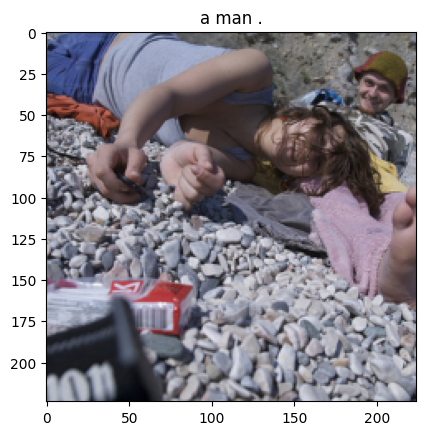

In [54]:
#show any 1
dataiter = iter(test_data_loader)
images,_,graph = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
#caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
caps,alphas = get_caps_from(img.unsqueeze(0),graph)
#plot_attention(img1, caps, alphas)

In [55]:
#generate caption
def get_caps_from_beam(features_tensors,graph):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        edge_features = model.decoder.edge_feature(graph.to(device))
        encoded_input= torch.cat((features, edge_features), dim=2)
        #caps,alphas,alphas_self = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
        caps,alphas = model.decoder.generate_caption_beam(encoded_input,vocab=train_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    #return caps,alphas, alphas_self
    return caps,alphas

In [ ]:
#show any 1
dataiter = iter(test_data_loader)
images,_,graph = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
#caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
caps,alphas = get_caps_from_beam(img.unsqueeze(0),graph)
caps,alphas = get_caps_from(img.unsqueeze(0),graph)
#plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(test_data_loader)
images,_,graph = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
#caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
caps,alphas = get_caps_from(img.unsqueeze(0),graph)
plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(test_data_loader)
images,_,graph = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
#caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
caps,alphas = get_caps_from(img.unsqueeze(0),graph)
plot_attention(img1, caps, alphas)

In [84]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Ensure NLTK's data for tokenization is downloaded
#nltk.download("punkt")

# Function to tokenize captions
def tokenize_captions(captions):
    return [nltk.word_tokenize(caption.lower()) for caption in captions]

#generate caption
def get_caps_from(features_tensors,graph):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        edge_features = model.decoder.edge_feature(graph.to(device))
        encoded_input= torch.cat((features, edge_features), dim=2)
        caps,alphas,alphas_self = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
        caption = ' '.join(caps)
        #show_image(features_tensors[0],title=caption)
    
    return caption,alphas, alphas_self

# Reference captions - should be a list of lists, where each sublist contains the correct captions for an image
reference_captions = []

# Generated captions - will be populated from model predictions
generated_captions = []

# Instantiate your model (assuming it's already trained)

# Iterate through the test dataset
for idx, (image, caption, graph) in enumerate(iter(test_data_loader)):
    img = image[0].detach().clone()
    caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
    error = '<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'
    # Add to the generated captions list
    if caps == error:
        continue
    generated_captions.append(caps)
    print('reference_captions :', caption)
    print('predicted_captions :', caps)
    # Add reference captions to the reference list
    reference_captions.append([caption.lower() for caption in caption])

# Tokenize generated captions
tokenized_generated_captions = tokenize_captions(generated_captions)

# Tokenize reference captions
tokenized_reference_captions = [tokenize_captions(captions) for captions in reference_captions]
print(tokenized_generated_captions)
print(tokenized_reference_captions)
# Calculate BLEU-1 (using unigram weights)
smoothing_function = SmoothingFunction().method1  # Smoothing to avoid zero-gram probabilities
bleu_1 = corpus_bleu(
    tokenized_reference_captions,
    tokenized_generated_captions,
    weights=(1, 0, 0, 0),
    smoothing_function=smoothing_function
)

# Calculate BLEU-2 (using bigram weights)
bleu_2 = corpus_bleu(
    tokenized_reference_captions,
    tokenized_generated_captions,
    weights=(0.5, 0.5, 0, 0),  # Weights for BLEU-2: 0.5 for unigrams, 0.5 for bigrams
    smoothing_function=smoothing_function
)

print(f"BLEU-1: {bleu_1}")
print(f"BLEU-2: {bleu_2}")


reference_captions : ['A little girl standing on her head .']
predicted_captions : a little girl in a pink shirt and blue jeans is jumping on a bed .
reference_captions : ['The dogs are running in the snow .']
predicted_captions : two dogs playing in the snow .
reference_captions : ['A small dog and a large dog in the snow .']
predicted_captions : a white dog and a black dog are in a snowy field .
reference_captions : ['Two french poodles romp on a snowy field']
predicted_captions : two dogs are running down a hill .
reference_captions : ['An adult hikes in the snow with a mountain in the background .']
predicted_captions : a person in a red jacket is walking through a snowy mountain .
reference_captions : ['A little girl pushing a baby doll stroller']
predicted_captions : a little girl in a pink shirt and pink pants is on a sidewalk .
reference_captions : ['A young girl steadies her aim with a camera']
predicted_captions : a young girl with a black shirt and a white shirt .
reference_

In [30]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Ensure NLTK's data for tokenization is downloaded
#nltk.download("punkt")

# Function to tokenize captions
def tokenize_captions(captions):
    return [nltk.word_tokenize(caption.lower()) for caption in captions]

#generate caption
def get_caps_from(features_tensors,graph):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        edge_features = model.decoder.edge_feature(graph.to(device))
        encoded_input= torch.cat((features, edge_features), dim=2)
        #caps,alphas,alphas_self = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
        caps,alphas = model.decoder.generate_caption(encoded_input,vocab=train_dataset.vocab)
        caption = ' '.join(caps)
        #show_image(features_tensors[0],title=caption)
    
    #return caption,alphas, alphas_self
    return caption,alphas

# Reference captions - should be a list of lists, where each sublist contains the correct captions for an image
reference_captions = []

# Generated captions - will be populated from model predictions
generated_captions = []

# Instantiate your model (assuming it's already trained)

# Iterate through the test dataset
for idx, (image, caption, graph) in enumerate(iter(test_data_loader)):
    img = image[0].detach().clone()
    #caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0),graph)
    caps,alphas = get_caps_from(img.unsqueeze(0),graph)
    error = '<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'
    # Add to the generated captions list
    if caps == error:
        continue
    generated_captions.append(caps)
    print('reference_captions :', caption)
    print('predicted_captions :', caps)
    # Add reference captions to the reference list
    reference_captions.append([caption.lower() for caption in caption])

# Tokenize generated captions
tokenized_generated_captions = tokenize_captions(generated_captions)

# Tokenize reference captions
tokenized_reference_captions = [tokenize_captions(captions) for captions in reference_captions]
print(tokenized_generated_captions)
print(tokenized_reference_captions)
# Calculate BLEU-1 (using unigram weights)
smoothing_function = SmoothingFunction().method1  # Smoothing to avoid zero-gram probabilities
bleu_1 = corpus_bleu(
    tokenized_reference_captions,
    tokenized_generated_captions,
    weights=(1, 0, 0, 0),
    smoothing_function=smoothing_function
)

# Calculate BLEU-2 (using bigram weights)
bleu_2 = corpus_bleu(
    tokenized_reference_captions,
    tokenized_generated_captions,
    weights=(0.5, 0.5, 0, 0),  # Weights for BLEU-2: 0.5 for unigrams, 0.5 for bigrams
    smoothing_function=smoothing_function
)

print(f"BLEU-1: {bleu_1}")
print(f"BLEU-2: {bleu_2}")


reference_captions : ['a person snowboarding over a large hump with onlookers in front of him']
predicted_captions : a man in a yellow jacket is sitting on a mountain .
reference_captions : ['Women who look alike are performing on a stage .']
predicted_captions : four people are in a white room in a crowd of <UNK> .
reference_captions : ['a dog rolls in the grass .']
predicted_captions : a dog is laying on the grass .
reference_captions : ['A man is standing at the shoreline on the beach with 4 dogs .']
predicted_captions : two dogs are running through the sand .
reference_captions : ['Man in blue padded suit training a black dog for search and rescue in a field .']
predicted_captions : a boy in a red shirt and black pants is jumping a rope in a field .
reference_captions : ['A white dog is following a black dog along the beach .']
predicted_captions : two dogs are running on the beach .
reference_captions : ['A surfer rides a wave under a red bridge .']
predicted_captions : a man is s